### Import lib

In [43]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import transformers
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from PIL import Image
from torch.utils.data import DataLoader
import random
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dir_path = Path("data")
train_dir = dir_path/"train"
test_dir = dir_path/"test"

#For kaggle
# train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
# test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

In [21]:
images = list(dir_path.glob("*/*/*.jpg"))
images[:10]

[WindowsPath('data/test/glioma/Te-glTr_0000.jpg'),
 WindowsPath('data/test/glioma/Te-glTr_0001.jpg'),
 WindowsPath('data/test/glioma/Te-glTr_0002.jpg'),
 WindowsPath('data/test/glioma/Te-glTr_0003.jpg'),
 WindowsPath('data/test/glioma/Te-glTr_0004.jpg'),
 WindowsPath('data/test/glioma/Te-glTr_0005.jpg'),
 WindowsPath('data/test/glioma/Te-glTr_0006.jpg'),
 WindowsPath('data/test/glioma/Te-glTr_0007.jpg'),
 WindowsPath('data/test/glioma/Te-glTr_0008.jpg'),
 WindowsPath('data/test/glioma/Te-glTr_0009.jpg')]

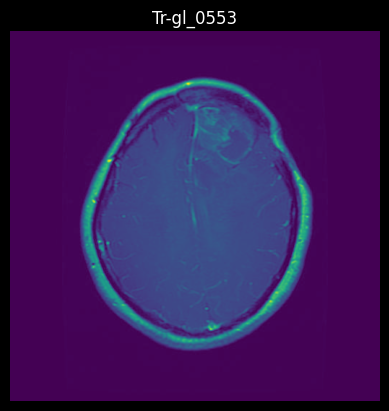

In [40]:
random_image = random.choice(images)
title = random_image.stem
img = Image.open(random_image)
plt.figure(facecolor="black")
plt.imshow(img)
plt.title(title,color="white")
plt.axis("off")
plt.show()

In [42]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

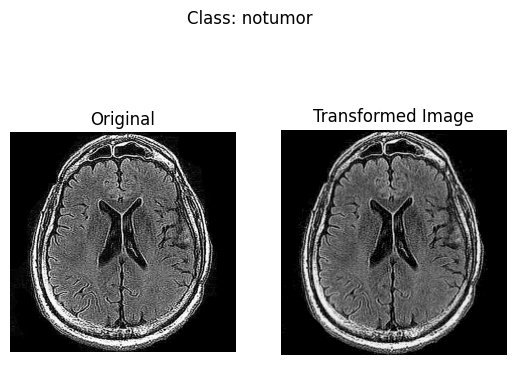

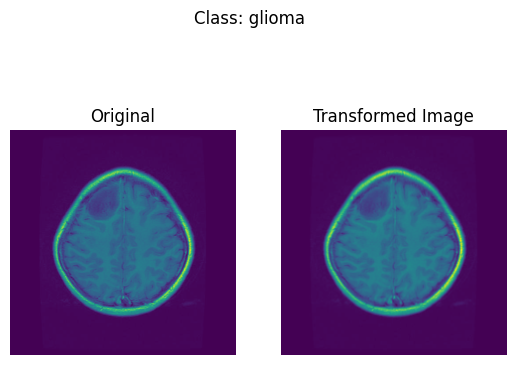

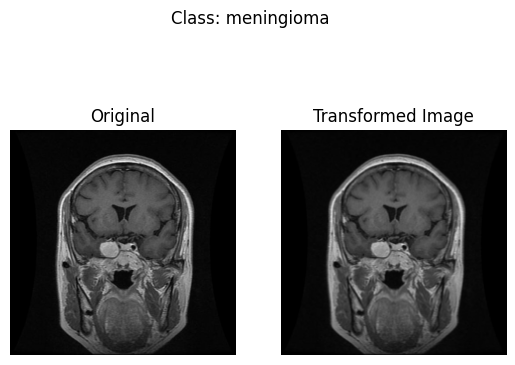

In [46]:
def plot_random(image_path_list,transform,n=3,seed=0):
    # sorted(image_path_list)
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path_list,k=n)

    for i in random_image_paths:
        # t = i.parent.stem
        with Image.open(i) as img:
            fig,ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(img)
            ax[0].set_title("Original")
            ax[0].axis("off")

            transform_img = transform(img)
            ax[1].imshow(transform_img.permute(1,2,0))
            ax[1].set_title("Transformed Image")
            ax[1].axis("off")

            fig.suptitle(f"Class: {i.parent.stem}")
    plt.show()


plot_random(images,data_transform,3)

In [44]:
def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))
    

train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transform, loader=safe_pil_loader)
test_dataset= datasets.ImageFolder(root=test_dir,transform=data_transform, loader=safe_pil_loader)

In [48]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

len(train_dataset), len(test_dataset), len(train_dataloader), len(test_dataloader)

(5712, 1311, 179, 41)

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt


model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=4,
    ignore_mismatched_sizes=True
)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for param in model.parameters():
    param.requires_grad = False

classifier_params = model.module.classifier.parameters() if isinstance(model, torch.nn.DataParallel) else model.classifier.parameters()
for param in classifier_params:
    param.requires_grad = True

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_model = []
train_acc_model = []
test_loss_model = []
test_acc_model = []

EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model.train()

    train_loss_epoch = 0
    train_acc_epoch = 0

    for batch_idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model(X).logits
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx} | Train loss: {loss.item():.5f} | Train acc: {acc:.2f}")

    train_loss_epoch /= len(train_dataloader)
    train_acc_epoch /= len(train_dataloader)

    model.eval()
    test_loss_epoch = 0
    test_acc_epoch = 0

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc

    test_loss_epoch /= len(test_dataloader)
    test_acc_epoch /= len(test_dataloader)

    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f} | Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")


    train_loss_model.append(train_loss_epoch)
    train_acc_model.append(train_acc_epoch)
    test_loss_model.append(test_loss_epoch)
    test_acc_model.append(test_acc_epoch)

In [ ]:
torch.save(model.state_dict(),"/kaggle/working/model.pth")

print("Model 1 saved successfully!")

In [ ]:
def plot_loss_curves(train_loss, train_acc, test_loss, test_acc, batches_per_epoch=1):
    num_epochs = len(train_loss)

    epochs = range(num_epochs)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()

plot_loss_curves(train_loss_model, train_acc_model, test_loss_model, test_acc_model, batches_per_epoch=1)